In [102]:
#pip install pandas numpy matplotlib seaborn

In [103]:
# 2. Importación de Librerías.
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from datetime import datetime

In [104]:
# 3. Definición de Constantes.
DB_FILENAME = 'gestion_produccion.db'

# 4. Configuración de Rutas.
try:
    # __file__ no está definido en notebooks, por lo que se usa os.getcwd() como alternativa.
    PROJECT_ROOT = os.path.dirname(os.path.abspath(__file__))
except NameError:
    PROJECT_ROOT = os.getcwd()

DB_PATH = os.path.join(PROJECT_ROOT, DB_FILENAME)

In [105]:
# 5. Carga de Datos en Variables Individuales.
print(f"Intentando conectar a la base de datos en: {DB_PATH}")
conn = None
try:
    conn = sqlite3.connect(DB_PATH)
    
    # Cargar cada tabla en un DataFrame específico.
    producto_df = pd.read_sql_query('SELECT * FROM producto', conn)
    print(f"Tabla 'producto' cargada en producto_df con {len(producto_df)} filas.")
    
    lote_df = pd.read_sql_query('SELECT * FROM lote', conn)
    print(f"Tabla 'lote' cargada en lote_df con {len(lote_df)} filas.")
    
    rol_df = pd.read_sql_query('SELECT * FROM rol', conn)
    print(f"Tabla 'rol' cargada en rol_df con {len(rol_df)} filas.")
    
    empleado_df = pd.read_sql_query('SELECT * FROM empleado', conn)
    print(f"Tabla 'empleado' cargada en empleado_df con {len(empleado_df)} filas.")

    produccion_df = pd.read_sql_query('SELECT * FROM produccion', conn)
    print(f"Tabla 'produccion' cargada en produccion_df con {len(produccion_df)} filas.")

    cliente_df = pd.read_sql_query('SELECT * FROM cliente', conn)
    print(f"Tabla 'cliente' cargada en cliente_df con {len(cliente_df)} filas.")

    venta_df = pd.read_sql_query('SELECT * FROM venta', conn)
    print(f"Tabla 'venta' cargada en venta_df con {len(venta_df)} filas.")

    asistencia_df = pd.read_sql_query('SELECT * FROM asistencia', conn)
    print(f"Tabla 'asistencia' cargada en asistencia_df con {len(asistencia_df)} filas.")

except sqlite3.Error as e:
    print(f"Error al conectar o leer la base de datos: {e}", file=sys.stderr)
finally:
    if conn:
        conn.close()

Intentando conectar a la base de datos en: c:\Users\Julian Waksmann\Documents\03 UNIVERSIDAD\labo\gestion_produccion.db
Tabla 'producto' cargada en producto_df con 10 filas.
Tabla 'lote' cargada en lote_df con 3954 filas.
Tabla 'rol' cargada en rol_df con 3 filas.
Tabla 'empleado' cargada en empleado_df con 16 filas.
Tabla 'produccion' cargada en produccion_df con 3954 filas.
Tabla 'cliente' cargada en cliente_df con 40 filas.
Tabla 'venta' cargada en venta_df con 11553 filas.
Tabla 'asistencia' cargada en asistencia_df con 7446 filas.


In [106]:
# Pre-procesamiento y Conversión de Tipos de Datos

# Se convierte la columna 'fecha_vto' del DataFrame de lotes.
lote_df['fecha_vto'] = pd.to_datetime(lote_df['fecha_vto'])

# Se convierte la columna 'fecha' del DataFrame de asistencia.
asistencia_df['fecha'] = pd.to_datetime(asistencia_df['fecha'])

print("Columnas de fecha convertidas a formato datetime exitosamente.")

Columnas de fecha convertidas a formato datetime exitosamente.


# Título: Análisis de Desperdicios por Vencimiento

--- Valor Total Desperdiciado por Producto ---
nombre
Muffins de arandanos             470877.027762
Budin de limon                   370592.874335
Grisines con sesamo              264819.700000
Yogur bebible de frutilla        243004.800000
Galletitas de avena              215498.836286
Tostadas de arroz                180933.228396
Bizcochos de grasa               178410.000000
Premezcla para pizza             134054.737001
Alfajor de maicena                96659.373734
Barra de cereal con chocolate     78532.498681
Name: valor_desperdiciado, dtype: float64


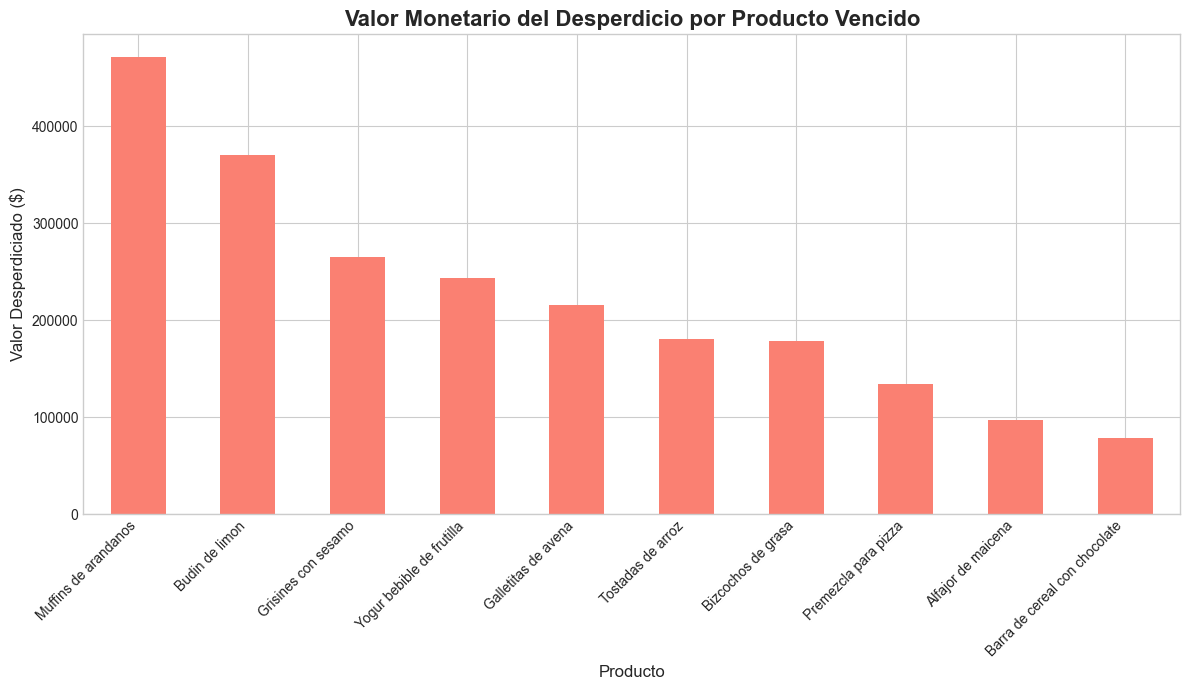

In [107]:
# 1. Definición de Constantes
# Se define la fecha de referencia para el análisis. Cualquier lote con fecha de
# vencimiento anterior a esta se considerará expirado.
FECHA_ANALISIS = datetime.now()

# 2. Identificación de Lotes Vencidos con Stock
# Se filtra el DataFrame de lotes para encontrar filas que cumplan ambas condiciones:
# a) La fecha de vencimiento es anterior a la fecha de análisis.
# b) La cantidad de inventario restante es mayor que cero.
lotes_vencidos_df = lote_df[(lote_df['fecha_vto'] < FECHA_ANALISIS) & (lote_df['cantidad'] > 0)].copy()

# 3. Cálculo del Valor del Desperdicio
# Se une el DataFrame de lotes vencidos con el de productos para acceder al precio de cada uno.
desperdicio_df = pd.merge(lotes_vencidos_df, producto_df, on='id_producto', how='left')

# Se calcula una nueva columna 'valor_desperdiciado'.
desperdicio_df['valor_desperdiciado'] = desperdicio_df['cantidad'] * desperdicio_df['precio']

# 4. Agregación de Resultados por Producto
# Se agrupan los datos por nombre de producto para sumar el valor total desperdiciado por cada uno.
desperdicio_por_producto = desperdicio_df.groupby('nombre')['valor_desperdiciado'].sum().sort_values(ascending=False)

print("--- Valor Total Desperdiciado por Producto ---")
if not desperdicio_por_producto.empty:
    print(desperdicio_por_producto)
else:
    print("No se encontraron lotes vencidos con stock remanente.")

# 5. Visualización de Resultados
if not desperdicio_por_producto.empty:
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))
    
    desperdicio_por_producto.plot(kind='bar', color='salmon')
    
    plt.title('Valor Monetario del Desperdicio por Producto Vencido', fontsize=16, weight='bold')
    plt.xlabel('Producto', fontsize=12)
    plt.ylabel('Valor Desperdiciado ($)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

--- Análisis de Puntualidad por Empleado para el Mes 6/2025 ---
                  promedio_retraso_min  total_llegadas_tarde
nombre                                                      
Sofia Diaz                    2.571429                     3
Javier Ramirez                1.166667                     2
Lucia Torres                  1.937500                     2
Diego Lopez                   0.555556                     1
Maria Rodriguez               1.250000                     1
Martin Gonzalez               0.950000                     1
Florencia Ortiz               1.176471                     1
Laura Sanchez                 0.777778                     1
Valentina Romero              0.555556                     1
Pedro Martinez                0.900000                     1
Camila Benitez                0.000000                     0
Carlos Gomez                  0.000000                     0
Juan Perez                    0.000000                     0
Ana Fernandez        

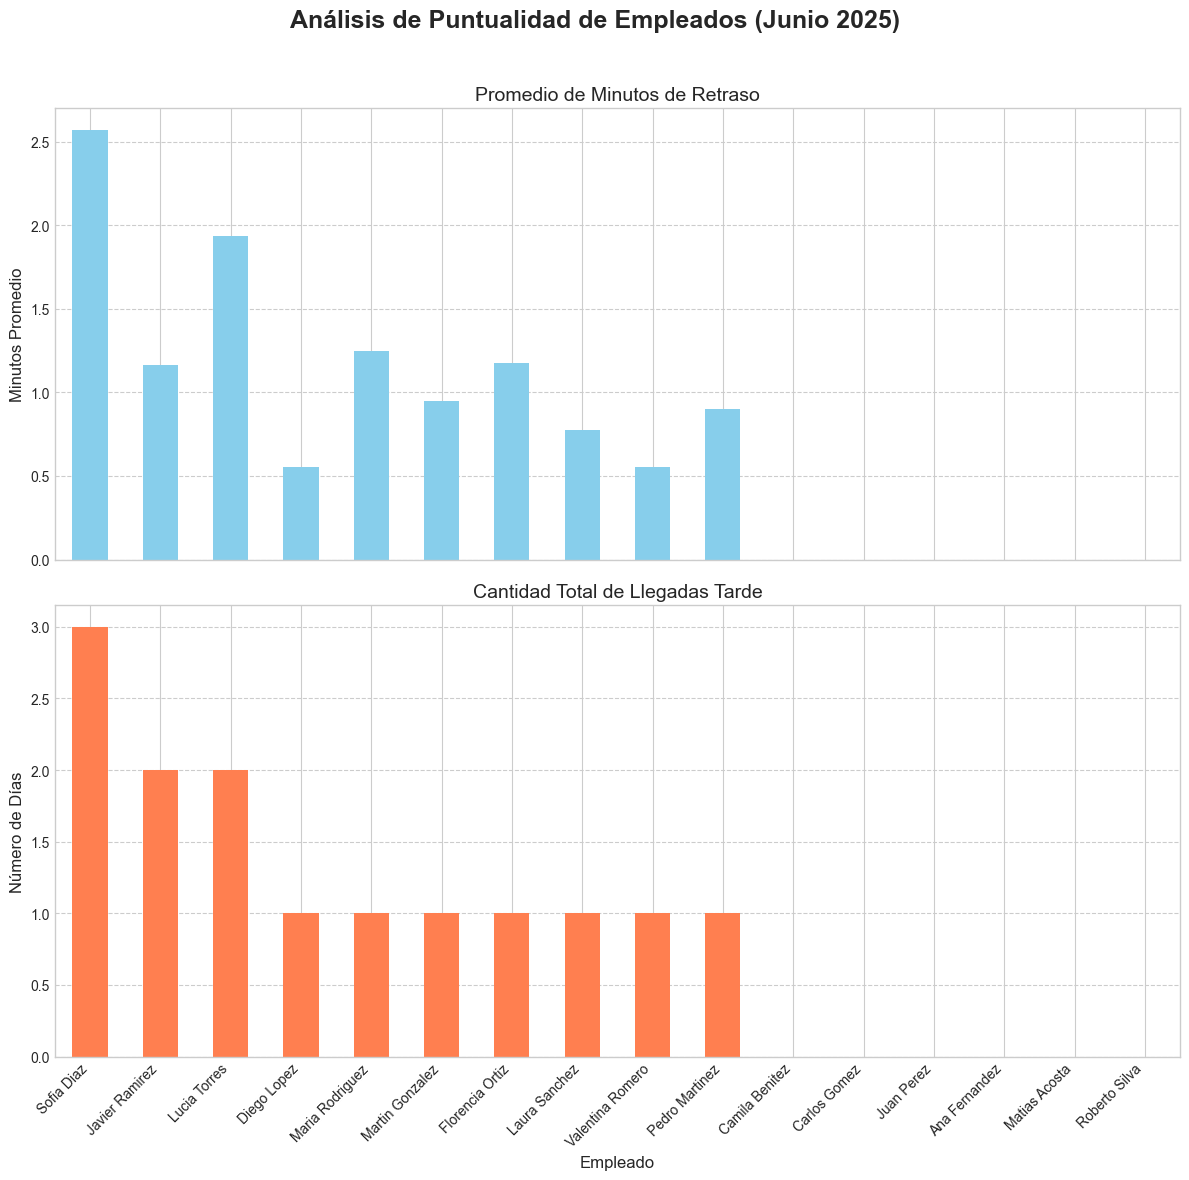

In [108]:
# 1. Definición de Constantes
HORA_ENTRADA = 8      # Hora de entrada oficial: 8:00 AM.
MES_ANALISIS = 6      # Mes a analizar: 6 (Junio).
ANO_ANALISIS = 2025   # Año de la simulación.

# 2. Filtrado de Datos por Mes
# Se filtran los registros de asistencia para incluir solo el mes y año de interés.
asistencia_mes_df = asistencia_df[
    (asistencia_df['fecha'].dt.month == MES_ANALISIS) &
    (asistencia_df['fecha'].dt.year == ANO_ANALISIS)
].copy()

# 3. Preparación de Datos de Entrada
# Se filtran únicamente los registros de 'entrada' del DataFrame ya filtrado por mes.
entradas_df = asistencia_mes_df[asistencia_mes_df['tipo'] == 'entrada'].copy()

# 4. Cálculo de Retraso
# Se calcula la diferencia en minutos entre la hora de entrada real y la hora oficial.
entradas_df['retraso_min'] = (
    (entradas_df['fecha'] - entradas_df['fecha'].dt.normalize().add(pd.Timedelta(hours=HORA_ENTRADA)))
    .dt.total_seconds() / 60
).apply(lambda x: max(0, x))

# 5. Enriquecimiento de Datos
# Se une el DataFrame de entradas con el de empleados para obtener los nombres.
asistencia_con_nombre_df = pd.merge(entradas_df, empleado_df, on='id_empleado', how='left')

# 6. Agregación de Métricas por Empleado
# Se agrupan los datos por nombre de empleado para calcular las métricas de puntualidad del mes.
analisis_puntualidad = asistencia_con_nombre_df.groupby('nombre').agg(
    promedio_retraso_min=('retraso_min', 'mean'),
    total_llegadas_tarde=('retraso_min', lambda x: (x > 0).sum())
).sort_values(by='total_llegadas_tarde', ascending=False)

print(f"--- Análisis de Puntualidad por Empleado para el Mes {MES_ANALISIS}/{ANO_ANALISIS} ---")
print(analisis_puntualidad)

# 7. Visualización de Resultados
if not analisis_puntualidad.empty:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
    fig.suptitle(f'Análisis de Puntualidad de Empleados (Junio {ANO_ANALISIS})', fontsize=18, weight='bold')

    # Gráfico de Retraso Promedio
    analisis_puntualidad['promedio_retraso_min'].plot(kind='bar', ax=ax1, color='skyblue')
    ax1.set_title('Promedio de Minutos de Retraso', fontsize=14)
    ax1.set_ylabel('Minutos Promedio', fontsize=12)
    ax1.grid(axis='y', linestyle='--')

    # Gráfico de Cantidad de Llegadas Tarde
    analisis_puntualidad['total_llegadas_tarde'].plot(kind='bar', ax=ax2, color='coral')
    ax2.set_title('Cantidad Total de Llegadas Tarde', fontsize=14)
    ax2.set_xlabel('Empleado', fontsize=12)
    ax2.set_ylabel('Número de Días', fontsize=12)
    ax2.grid(axis='y', linestyle='--')

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print(f"No se encontraron datos de asistencia para el mes {MES_ANALISIS}/{ANO_ANALISIS}.")

--- Porcentaje de Merma Promedio por Producto ---
nombre
Grisines con sesamo              28.611801
Bizcochos de grasa               25.650010
Muffins de arandanos             24.721257
Tostadas de arroz                22.696760
Budin de limon                   21.316801
Galletitas de avena              20.191977
Barra de cereal con chocolate    19.556841
Yogur bebible de frutilla        18.453352
Alfajor de maicena               15.057440
Premezcla para pizza             13.015774
Name: porcentaje_merma, dtype: float64


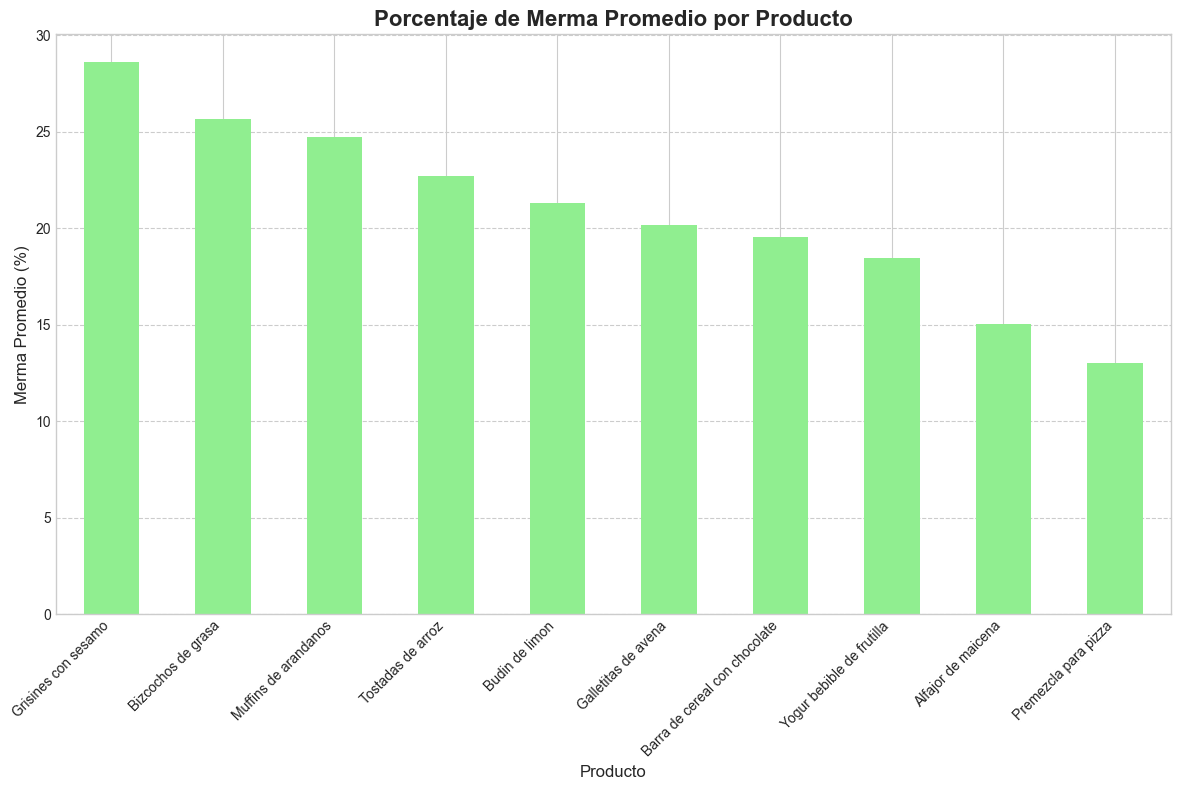

In [109]:
# 1. Enriquecimiento de Datos de Producción
# Se une el DataFrame de producción con el estado final de los lotes para obtener la cantidad remanente.
produccion_lotes_df = pd.merge(produccion_df, lote_df, on='id_lote', how='left')

# Se añade la información de los productos para poder agrupar por nombre.
produccion_completa_df = pd.merge(produccion_lotes_df, producto_df, on='id_producto', how='left')

# 2. Cálculo de Merma por Lote
# Se calcula el porcentaje de merma, que es la proporción del lote que no se vendió.
# Se usa np.where para evitar divisiones por cero si un lote se creó con cantidad_out = 0.
produccion_completa_df['porcentaje_merma'] = np.where(
    produccion_completa_df['cantidad_out'] > 0,
    (produccion_completa_df['cantidad'] / produccion_completa_df['cantidad_out']) * 100,
    0
)

# 3. Agregación de Métricas por Producto
# Se calcula el promedio de merma para cada producto.
merma_por_producto = produccion_completa_df.groupby('nombre')['porcentaje_merma'].mean().sort_values(ascending=False)

print("--- Porcentaje de Merma Promedio por Producto ---")
print(merma_por_producto)

# 4. Visualización de Resultados
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))

merma_por_producto.plot(kind='bar', color='lightgreen')

plt.title('Porcentaje de Merma Promedio por Producto', fontsize=16, weight='bold')
plt.xlabel('Producto', fontsize=12)
plt.ylabel('Merma Promedio (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# Desperdicio por Cantidad de Unidades en junio

--- Cantidad Total de Unidades Desperdiciadas (Vencimiento en Junio 2025) ---
nombre
Grisines con sesamo              22072.0
Galletitas de avena              15492.0
Tostadas de arroz                11134.0
Barra de cereal con chocolate     9495.0
Bizcochos de grasa                9291.0
Budin de limon                    7998.0
Premezcla para pizza              6812.0
Muffins de arandanos              6085.0
Alfajor de maicena                4253.0
Yogur bebible de frutilla         4166.0
Name: cantidad, dtype: float64


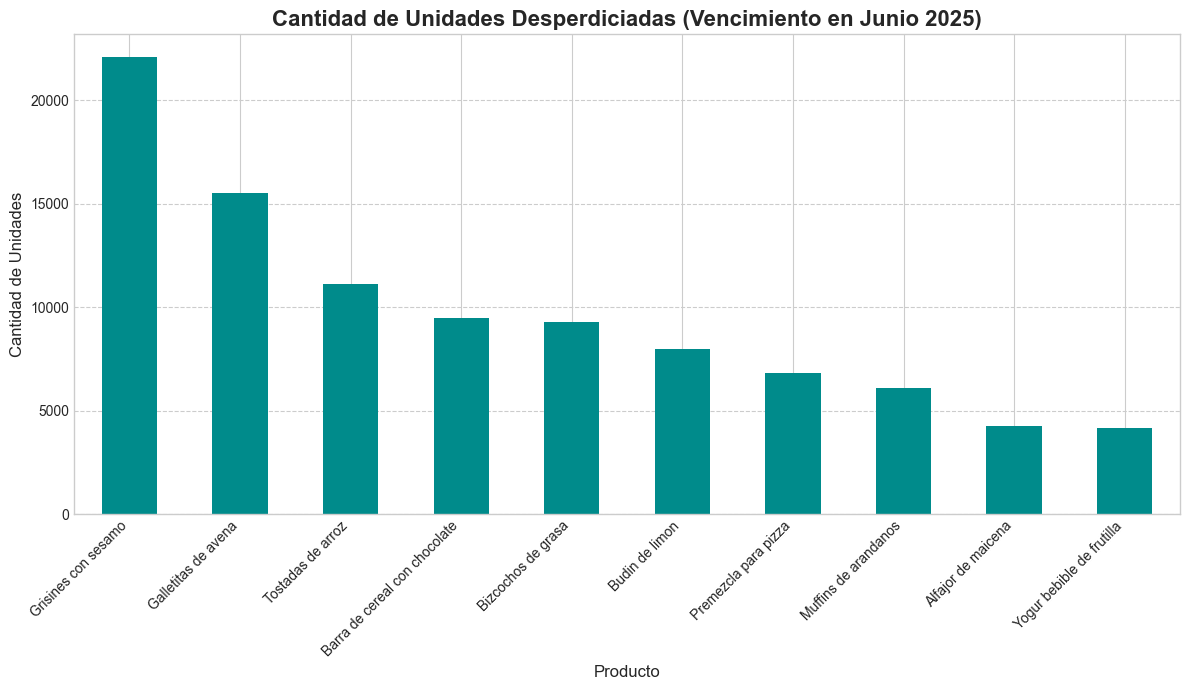

In [111]:
# 1. Definición de Constantes
MES_ANALISIS = 6      # Mes a analizar: 6 (Junio).
# El año se obtiene del año actual para que coincida con la simulación de datos.
ANO_ANALISIS = datetime.now().year 
FECHA_ANALISIS = datetime.now()

# 2. Filtrado de Lotes Vencidos en Junio
# Se filtra el DataFrame de lotes para encontrar filas que cumplan todas las condiciones:
# a) La fecha de vencimiento corresponde al mes y año de análisis.
# b) La fecha de vencimiento es anterior a la fecha de hoy (para asegurar que esté vencido).
# c) La cantidad de inventario restante es mayor que cero.
lotes_vencidos_junio_df = lote_df[
    (lote_df['fecha_vto'].dt.month == MES_ANALISIS) &
    (lote_df['fecha_vto'].dt.year == ANO_ANALISIS) &
    (lote_df['fecha_vto'] < FECHA_ANALISIS) &
    (lote_df['cantidad'] > 0)
].copy()

# 3. Enriquecimiento de Datos
# Se une el DataFrame filtrado con el de productos para obtener los nombres.
desperdicio_junio_df = pd.merge(lotes_vencidos_junio_df, producto_df, on='id_producto', how='left')

# 4. Agregación de Cantidades por Producto
# Se agrupan los datos por nombre de producto y se suma la 'cantidad' de unidades.
desperdicio_junio_por_cantidad = desperdicio_junio_df.groupby('nombre')['cantidad'].sum().sort_values(ascending=False)

print(f"--- Cantidad Total de Unidades Desperdiciadas (Vencimiento en Junio {ANO_ANALISIS}) ---")
if not desperdicio_junio_por_cantidad.empty:
    print(desperdicio_junio_por_cantidad)
else:
    print(f"No se encontraron unidades desperdiciadas en lotes vencidos en junio de {ANO_ANALISIS}.")

# 5. Visualización de Resultados
if not desperdicio_junio_por_cantidad.empty:
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))
    
    desperdicio_junio_por_cantidad.plot(kind='bar', color='darkcyan')
    
    plt.title(f'Cantidad de Unidades Desperdiciadas (Vencimiento en Junio {ANO_ANALISIS})', fontsize=16, weight='bold')
    plt.xlabel('Producto', fontsize=12)
    plt.ylabel('Cantidad de Unidades', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

# Análisis de Tendencia de Ventas Mensuales

C:\Users\Julian Waksmann\AppData\Local\Temp\ipykernel_22536\1082125169.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ingresos_mensuales = ventas_temporales_df['ingresos'].resample('M').sum()


--- Ingresos Totales por Mes ---
fecha_venta
2024-08-31    $16,125.35
2024-09-30    $60,588.65
2024-10-31    $75,586.10
2024-11-30    $64,669.85
2024-12-31    $72,975.55
2025-01-31    $69,045.20
2025-02-28    $63,716.60
2025-03-31    $67,142.00
2025-04-30    $75,411.70
2025-05-31    $70,119.00
2025-06-30    $69,964.15
2025-07-31    $68,712.70
2025-08-31    $49,294.15
Freq: ME, Name: ingresos, dtype: object


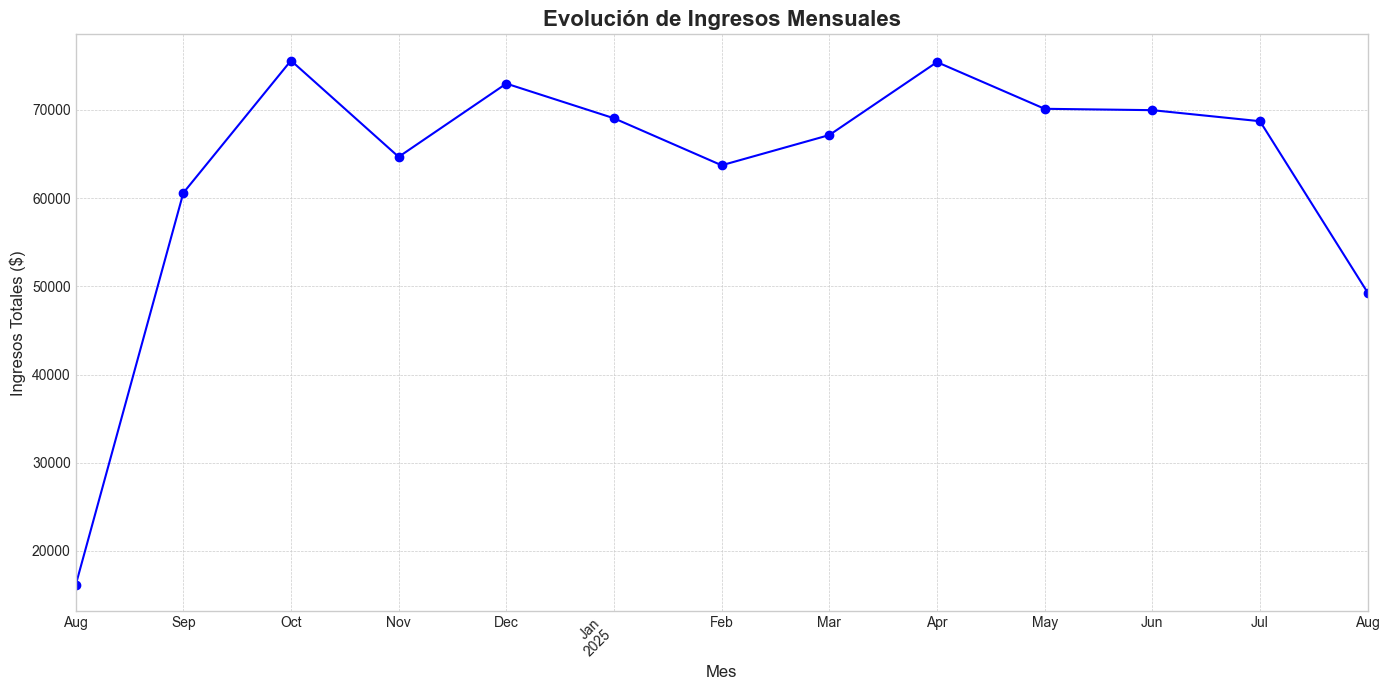

In [112]:
# 1. Preparación de Datos de Ventas
# Se asegura de que la columna de fecha de venta esté en formato datetime.
venta_df['fecha_venta'] = pd.to_datetime(venta_df['fecha_venta'])

# Se vuelve a unir con productos para asegurar que tenemos los precios y calcular ingresos.
venta_completa_df = pd.merge(venta_df, producto_df, on='id_producto', how='left')
venta_completa_df['ingresos'] = venta_completa_df['cantidad'] * venta_completa_df['precio']

# Se establece la fecha de venta como el índice del DataFrame, lo cual es
# una práctica estándar para trabajar con series temporales.
ventas_temporales_df = venta_completa_df.set_index('fecha_venta')

# 2. Agregación de Ingresos por Mes
# Se utiliza el método 'resample' con el código 'M' para agrupar las fechas por mes.
# Luego, se suma el total de 'ingresos' para cada grupo mensual.
ingresos_mensuales = ventas_temporales_df['ingresos'].resample('M').sum()

print("--- Ingresos Totales por Mes ---")
# Se formatea la salida para que sea más legible.
print(ingresos_mensuales.map('${:,.2f}'.format))

# 3. Visualización de la Tendencia
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 7))

ingresos_mensuales.plot(kind='line', marker='o', linestyle='-', color='b')

plt.title('Evolución de Ingresos Mensuales', fontsize=16, weight='bold')
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Ingresos Totales ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Análisis del Valor de Producción por Operario

--- Valor Monetario Total Producido por Operario ---
nombre_y
Javier Ramirez      $1,508,129.75
Matias Acosta       $1,494,229.00
Pedro Martinez      $1,486,124.40
Juan Perez          $1,386,723.05
Maria Rodriguez     $1,385,061.70
Sofia Diaz          $1,369,322.90
Lucia Torres        $1,369,163.35
Laura Sanchez       $1,313,484.00
Martin Gonzalez     $1,307,699.95
Diego Lopez         $1,291,063.55
Camila Benitez      $1,284,050.25
Valentina Romero    $1,222,991.25
Name: valor_producido, dtype: object


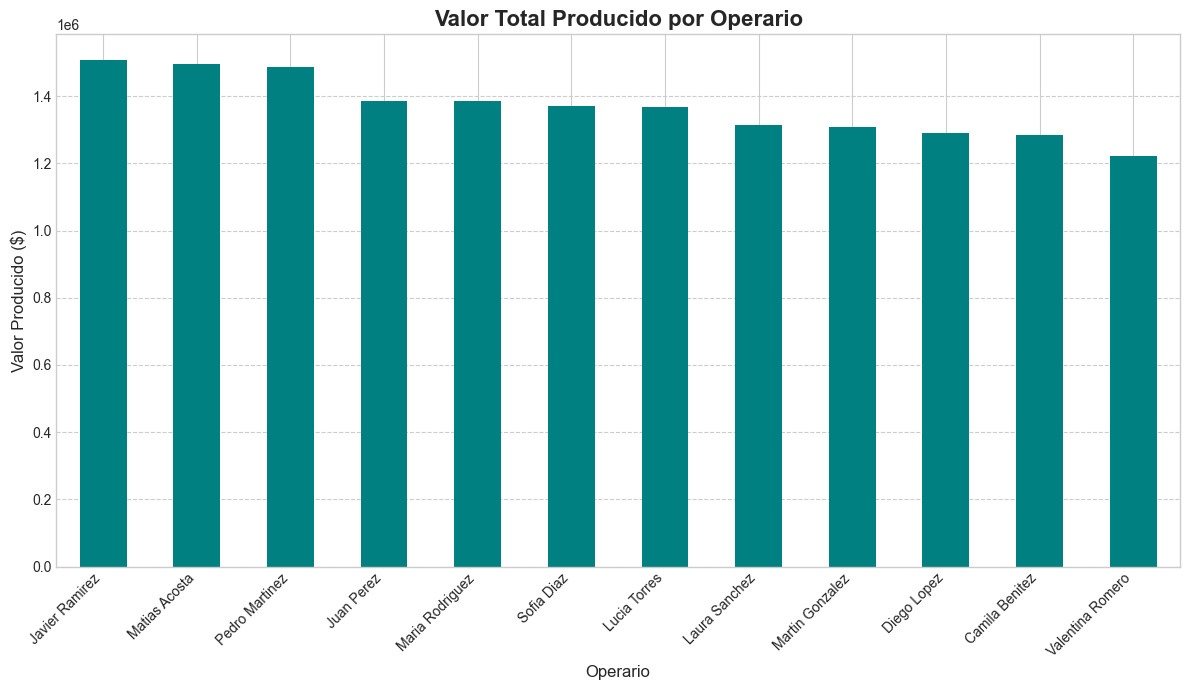

In [113]:
# 1. Enriquecimiento de Datos de Producción
# Se une el DataFrame de producción con el de lotes para obtener el id_producto.
produccion_con_producto_df = pd.merge(produccion_df, lote_df, on='id_lote', how='left')

# Se une con el DataFrame de productos para obtener el precio de cada unidad producida.
produccion_con_precio_df = pd.merge(produccion_con_producto_df, producto_df, on='id_producto', how='left')

# Se une con el DataFrame de empleados para obtener el nombre del operario.
produccion_con_empleado_df = pd.merge(produccion_con_precio_df, empleado_df, on='id_empleado', how='left')

# 2. Cálculo del Valor Producido
# Se calcula el valor monetario de cada lote producido (cantidad * precio).
produccion_con_empleado_df['valor_producido'] = produccion_con_empleado_df['cantidad_out'] * produccion_con_empleado_df['precio']

# 3. Filtrado por Rol de Operario
# Se asegura de que el análisis incluya únicamente a los empleados con el rol de 'Operario'.
operarios_df = pd.merge(empleado_df, rol_df[rol_df['nombre'] == 'Operario'], on='id_rol')
produccion_operarios_df = produccion_con_empleado_df[produccion_con_empleado_df['id_empleado'].isin(operarios_df['id_empleado'])]

# 4. Agregación de Valor por Operario
# Se agrupan los datos por nombre de operario y se suma el valor total producido.
# El nombre del empleado está en 'nombre_y' debido a los merges previos.
valor_por_operario = produccion_operarios_df.groupby('nombre_y')['valor_producido'].sum().sort_values(ascending=False)

print("--- Valor Monetario Total Producido por Operario ---")
print(valor_por_operario.map('${:,.2f}'.format))

# 5. Visualización de Resultados
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))

valor_por_operario.plot(kind='bar', color='teal')

plt.title('Valor Total Producido por Operario', fontsize=16, weight='bold')
plt.xlabel('Operario', fontsize=12)
plt.ylabel('Valor Producido ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()